In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from lib.diffusion2d_tools import animate2d, animate3d
mpl.rc('animation', html='jshtml')

# 2D Steady-State Reaction Diffusion Equation

In this example we consider the 2D steady-state reaction-diffusion equation, _i.e._, the diffusion equation with a source term $\dot{N}(C)$ due to a chemical reaction. We will consider a first-order reaction $\dot{N}=-k_1 C$ in a square domain of size $L$. The situation is described by the partial differential equation
\begin{equation}
D \left( \frac{\partial^2 C}{\partial x^2} + \frac{\partial^2 C}{\partial y^2} \right) - k_1 C = 0
\end{equation}
At the boundaries of the domain, the concentration is fixed at a bulk concentration $C_0$. The differential equation can be made dimensionless with a length scale $L$ and concentration $C_0$ which gives
\begin{equation}
\left( \frac{\partial^2 c}{\partial x^2} + \frac{\partial^2 c}{\partial y^2} \right) - \phi^2 c = 0 ,
\end{equation}
where we have introduced the _Thiele modulus_ $$\phi=\sqrt{\frac{k_1 L^2}{D}}.$$ The Thiele modulus measures the relative rate of reaction to diffusion. Our goal is to determine how the minimum concentration in the domain depends on the Thiele modulus.

## Finite Difference Discretization

In order to solve this problem numerically, we discretize the spatial domain into an $n\times n$ grid with a grid spacing $\Delta x=\Delta y=\Delta$. The discrete coordinates on this grid are $x_i=i\Delta x$ and $y_j=j\Delta y$. A point $(x_i,y_j)$ on the grid is defined by the indices $i$ and $j$ with $0\leq i,j \leq n-1$. Our goal is now to determine the $n^2$ unknown concentration values $c_{ij}=c(x_i,y_i)$ at these points.

A finite difference discretization of the differential equation is 
\begin{equation}
\frac{c(x+\Delta x,y)-2c(x,y)+c(x-\Delta x,y)}{(\Delta x)^2}
+ \frac{c(x,y+\Delta y)-2c(x,y)+c(x,y-\Delta y)}{(\Delta y)^2} - \phi^2 c(x,y) = 0 ,
\end{equation}
which yields an algebraic equation of the form
\begin{equation}
\frac{c_{i+1,j}-2c_{i,j}+c_{i-1,j}}{\Delta^2}
+ \frac{c_{i,j+1}-2c_{i,j}+c_{i,j-1}}{\Delta^2} - \phi^2 c_{i,j} = 0 .
\end{equation}

For the numerical solution, it will be useful to rearrange the unkown concentrations $c_{ij}$ in a long vector rather than on a grid. To do this, we need to convert the 2D indices $i,j$ into a global index $k$. This can be accomplished by defining $$k=i+j\cdot n.$$

The following schematic illustrates the conversion from 2D indices to a single global index. The image is adopted from the book *Numerical Methods with Chemical Engineering Applications* by Kevin Dorfman and Prodromos Daoutidis.

![Image of the discrete node grid](assets/node-grid.png)


With the above definition of $k$, the discretized equation becomes
\begin{equation}
\frac{c_{k+1}-2c_{k}+c_{k-1}}{\Delta^2}
+ \frac{c_{k+n}-2c_{k}+c_{k-n}}{\Delta^2} - \phi^2 c_{k} = 0 .
\end{equation}
We see that the entire equation system can be conveniently represented in matrix form $$\mathbf{A}\mathbf{c}=\mathbf{b}.$$

We are going to assemble this matrix for interior nodes, edges, and corners separately.

### Interior nodes

The finite difference equation can be applied for the interior nodes $1\leq i,j \leq n-2$ which yields a total of $(n-2)^2$ equations of the form
\begin{equation}
{c_{k+1}+c_{k-1}}+{c_{k+n}+c_{k-n}} - (4 + \phi^2 \Delta^2) c_{k} = 0 .
\end{equation}
The corresponding entries can be stored in the matrix $\mathbf{A}$ by two nested for-loops.

In [2]:
def interior(A,n,phi):
  for i in range(1,n-1):
    for j in range(1,n-1):
      k = j*n + i
      A[k,k] = -4 - dx**2*phi**2
      A[k,k+1] = 1
      A[k,k-1] = 1
      A[k,k+n] = 1
      A[k,k-n] = 1
  return A

### Domain edges

At the boundaries of the domain, we need to implement the boundary conditions for the particular problem. Here, the dimensionless concentration is constant $c=1$ (Dirichlet boundary conditions) which translates into the following equations
\begin{align}
c_{i,0} &= 1 \qquad 1 \leq i \leq n-2 \\
c_{i,n-1} &= 1 \qquad 1 \leq i \leq n-2 \\
c_{0,j} &= 1 \qquad 1 \leq j \leq n-2 \\
c_{n-1,j} &= 1 \qquad 1 \leq j \leq n-2 \\
\end{align}
These $4\cdot(n-2)$ equations can be stored in the matrix $\mathbf{A}$ and the vector $\mathbf{b}$ by four separate for-loops.

In [3]:
def edges(A,b,n):
  # bottom j = 0
  for i in range(1,n-1):
    k = i
    A[k,k] = 1
    b[k] = 1
  # top j = n-1
  for i in range(1,n-1):
    k = (n-1)*n + i
    A[k,k] = 1
    b[k] = 1
  # left i = 0
  for j in range(1,n-1):
    k = j*n
    A[k,k] = 1
    b[k] = 1
  # right i = n-1
  for j in range(1,n-1):
    k = j*n + n-1
    A[k,k] = 1
    b[k] = 1
  return A,b

### Corners

Some care has to be taken at the corners of the domain. One can in principle specify boundary conditions that impose two different concentrations on the adjacent edges, which would lead to an apparent discontinuity at the corner. By convention, this is dealt with by taking the average of the two edges to fix the concentration at the corner.
\begin{align}
c_{0,0} &= \frac{c_\text{left}+c_\text{bottom}}{2} \\
c_{0,n-1} &= \frac{c_\text{left}+c_\text{top}}{2} \\
c_{n-1,0} &= \frac{c_\text{right}+c_\text{bottom}}{2} \\
c_{n-1,n-1} &= \frac{c_\text{right}+c_\text{top}}{2}
\end{align}
In our case, the average value is still one since all boundaries are kept at the same fixed concentration. The 4 equations for the four corners can be written directly in the matrix $\mathbf{A}$ and the vector $\mathbf{b}$.

In [4]:
def corners(A,b,n):
  # bottom left i = 0, j = 0
  k = 0
  A[k,k] = 1
  b[k] = 1
  # bottom right i = n-1, j = 0
  k = n-1
  A[k,k] = 1
  b[k] = 1
  # top left i = 0, j = n-1
  k = (n-1)*n
  A[k,k] = 1
  b[k] = 1
  # top right i = n-1, j = n-1
  k = (n-1)*n + n-1
  A[k,k] = 1
  b[k] = 1
  return A,b

### Assembling and solving the linear system

We have now collected $(n-2)^2$ equations for the interior nodes, $4(n-2)$ equations for the edges, and 4 equations for the corners, giving us a total of $$(n-2)^2+4(n-2)+4=n^2$$ equations in the form
$$\mathbf{A}\mathbf{c}=\mathbf{b}.$$
The solution of this equation thus is the concentration vector $\mathbf{c}$ we are looking for.

In [5]:
def assemble_diffusion_reaction_system(n,phi):
  A = np.zeros((n**2,n**2))
  b = np.zeros(n**2)
  A = interior(A,n,phi)
  A,b = edges(A,b,n)
  A,b = corners(A,b,n)
  return A,b

In [6]:
def solve_diffusion_reaction_system(n,phi):
  A,b = assemble_diffusion_reaction_system(n,phi)
  C = np.linalg.solve(A,b)
  return C

We can finally put our machinery to action. We define the number $n$ of discrete  points in each direction, create the grid $(x,y)$, and obtain the solution for the concentration field $c(x,y)$.

In [7]:
n = 41 # number of points
phi = 1.0 # Thiele modulus

L = 1 # domain size
dx = L/(n-1) # grid spacing

# solve the reaction-diffusion problem
C = solve_diffusion_reaction_system(n,phi)

 To plot the solution, we define a meshgrid and convert the solution vector back into a 2D array.

In [8]:
# create the grid
x = np.arange(0,L+dx,dx)
x, y = np.meshgrid(x, x)
C = C.reshape(n,n)

# plot the solution
fig, ax = plt.subplots(subplot_kw={'projection': '3d'});
surf = ax.plot_surface(x,y,C,cmap=mpl.cm.coolwarm)
fig.colorbar(surf, label=r'$C/C_0$')
ax.set_title(r'Concentration Profile $\phi=$%.2f'%phi)
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.close()

### Exploring the effect of the parameters on the solution

In the widget below, you can choose different parameters to see their effect on the solution.

In [9]:
import ipywidgets as widgets
import hublib.ui as ui

def plot_steady(name='', value=''):
    
    # set parameters
    n = n_widget.value # number of points
    phi = phi_widget.value # Thiele modulus
    L = 1 # domain size
    dx = L/(n-1) # grid spacing
    cmin = 0.5
    
    # create the grid
    x = np.linspace(0,L,n)
    x, y = np.meshgrid(x, x)
    C = solve_diffusion_reaction_system(n,phi).reshape(n,n)
    
    with out_widget:
        out_widget.clear_output(wait=True)
        # plot the solution
        fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
        surf = ax.plot_surface(x,y,C,cmap=mpl.cm.coolwarm,vmin=cmin)
        cbar = fig.colorbar(surf,label=r'$C/C_0$')
        ax.set_zlim(cmin,)
        ax.set_title(r'Concentration Profile for $\phi=$%.2f'%phi_widget.value)
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')
        display(fig)
        plt.close()
        
n_widget = ui.Integer(
    name = 'n',
    desc = 'number of grid points per direction',
    value = 41,
    cb = plot_steady
)

phi_widget = ui.Number(
    name = 'phi',
    desc = 'Thiele modulus',
    value = 1.0,
    cb = plot_steady
)

out_widget = widgets.Output(layout=widgets.Layout())

plot_steady()

ui.Form([out_widget,n_widget,phi_widget])

<IPython.core.display.Javascript object>

Group(children=(Output(), Integer(children=(HTML(value='<div data-toggle="popover" title="number of grid point…

## Dependence of the minimum concentration on the Thiele modulus

Because of the symmetry of the problem, we expect the minimum concentration at the center of the domain. We can obtain the center concentration from the solution vector $\mathbf{c}$.

In [10]:
def center_concentration(n,phi):
  C = solve_diffusion_reaction_system(n,phi)
  return C[(n-1)//2*n+(n-1)//2]

We can now compute the center concentration for a range of different Thiele modulus values, and plot the results for the minimum concentration.

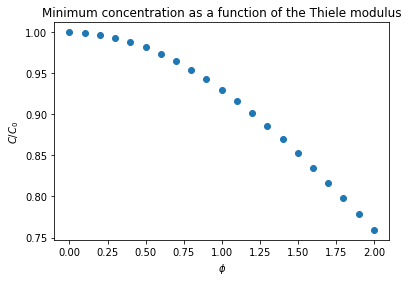

In [11]:
phi_range = np.linspace(0,2,21)
cs = [ center_concentration(n,p) for p in phi_range ]

plt.plot(phi_range,cs,'o')
plt.xlabel(r'$\phi$')
plt.ylabel(r'$C/C_0$')
plt.title(r'Minimum concentration as a function of the Thiele modulus')
plt.show()

## Transient Solution

In non-dimensionall form, the diffusion equation with a first-order chemical reaction reads
\begin{equation}
\frac{\partial c}{\partial t} = \left( \frac{\partial^2 c}{\partial x^2} + \frac{\partial^2 c}{\partial y^2} \right) - \phi^2 c .
\end{equation}
We have seen earlier that the finite difference discretization of the Laplacian can also be used to solve the transient diffusion equation, where we used the forward Euler scheme to discretize the time derivative
\begin{equation}
c(x,y,t+\Delta t) = c(x,y,t) + \Delta t \frac{\partial c}{\partial t} .
\end{equation}
With the above conventions for indexing concentrations on a grid, the discrete time stepping can thus be written
\begin{equation}
c_k(t+\Delta t) = c_k + \Delta t \left[ \frac{c_{k+1}-2c_{k}+c_{k-1}}{\Delta^2}
+ \frac{c_{k+n}-2c_{k}+c_{k-n}}{\Delta^2} - \phi^2 c_{k} \right] .
\end{equation}
For constant concentration boundary conditions at the edges of the domain, this can be written in matrix form as
\begin{equation}
\mathbf{c}(t+\Delta t) = \left( \mathsf{I} + \frac{\Delta t}{\Delta^2} \mathbf{A} \right) \mathbf{c}(t) ,
\end{equation}
where the matrix $\mathbf{A}$ only contains the entries for the interior nodes as defined above.

We can thus easily implement a function that updates the concentration for a number of time steps and returns the result as an array of concentration vectors.

In [12]:
def transient_reaction_diffusion(n,phi,steps):
  A = np.zeros((n**2,n**2))
  A = interior(A,n,phi)
  T = np.eye(n**2) + dt/dx**2*A
  C = np.zeros((steps+1,n**2))
  C[0] = np.ones(n**2)
  for t in range(steps):
    C[t+1] = T@C[t]
  return C

To put this to work, we define the time step and the desired time interval and call the above function to obtain the transient concentration profile. Remember that the forward Euler scheme is prone to instabilities if the time step is too large. In this particular case, we need to ensure that $\Delta t<\frac{2\Delta^2}{4+\phi^2\Delta^2}$. Be careful when changing the time to larger values in the following cell, as the calculations may exhaust the available memory.



In [13]:
dt = 0.25*dx**2
time = 0.4
steps = int(time/dt)
phi = 1.0
cmin = center_concentration(n,phi)
C = transient_reaction_diffusion(n,phi,steps)

The profiles can be visualized as a surface plot or as a heatmap. _Note that generating the animations can take a while depending on the number of frames._

In [14]:
animate3d(C,dt,phi,frames=10,interval=100,cmin=cmin)

In [15]:
animate2d(C,dt,phi,frames=10,interval=100,cmin=cmin)

We can also plot the transient behavior of the center concentration.

In [16]:
cs = C[:,(n-1)//2*n+(n-1)//2]
plt.plot(np.linspace(0,time,steps+1),cs,'-')
plt.xlabel('t [s]')
plt.ylabel(r'$C_\mathrm{center}/C_0$')
plt.title(r'Time dependence of the center concentration for $\phi$=%.2f'%phi)
plt.close()

In the widget below, you can explore the effect of the Thiele modulus on the transient behavior of the center concentration. Note that the forward Euler scheme will become unstable when the Thiele modulus becomes too large.

In [17]:
def plot_transient(name='', value=''):
    
    # set parameters
    n = n_widget2.value # number of points
    phi = phi_widget2.value # Thiele modulus
    L = 1 # domain size
    dx = L/(n-1) # grid spacing
    
    dt = 2.0/(4.0/dx**2+phi**2) # time step needs to satisfy stability criterion
    time = time_widget2.value
    steps = int(time/dt)
    ts = np.linspace(0,time,steps+1)
    
    # create the grid
    x = np.linspace(0,L,n)
    x, y = np.meshgrid(x, x)
    C = transient_reaction_diffusion(n,phi,steps)
    cs = C[:,(n-1)//2*n+(n-1)//2]
    
    with out_widget2:
        out_widget2.clear_output(wait=True)
        # plot the solution
        plt.plot(ts,cs,'-')
        plt.xlabel(r'$t$')
        plt.ylabel(r'$C_\mathrm{center}/C_0$')
        plt.title(r'Time dependence of the center concentration for $\phi$=%.2f'%phi)
        display(plt.gcf())
        plt.close()
        
n_widget2 = ui.Integer(
    name = 'n',
    desc = 'number of grid points per direction',
    value = 41,
    cb = plot_transient
)
phi_widget2 = ui.Number(
    name = 'phi',
    desc = 'Thiele modulus',
    value = 1.0,
    cb = plot_transient
)
time_widget2 = ui.Number(
    name = 'time',
    value = 0.4,
    cb = plot_transient
)

out_widget2 = widgets.Output(layout=widgets.Layout())

plot_transient()

ui.Form([out_widget2,n_widget2,time_widget2,phi_widget2])

Group(children=(Output(), Integer(children=(HTML(value='<div data-toggle="popover" title="number of grid point…

## Exercises

1. Implement the above finite-difference solution for the 2D reaction-diffusion system in Matlab. Use a grid of $41\times41$ nodes with spacing $\Delta x=1/40$ for a domain of side length $L=1$.
2. Plot the 2D steady-state concentration profile for three different values of the Thiele modulus in the range $0\leq\phi\leq 2$. 
3. Due to the symmetry of the problem, we expect the minimum concentration in the center of the system (the entry $c_{\lfloor\frac{n}{2}\rfloor,\lfloor\frac{n}{2}\rfloor}$). Use your Matlab script to plot the minimum concentration as a function of the Thiele modulus in the range $0\leq\phi\leq 2$.

1. Implement a Matlab script that updates the 2D concentration profile for a number of time steps and stores the result as an array of concentration vectors. Use a time step $\Delta t=1.5\cdot10^{-4}$.
2. Plot the concentration profile at three different times for a Thiele modulus of $\phi=1$. Choose times $t\leq0.4$ such that the transient behavior is illustrated.
3. Plot the minimum concentration as a function of time for three different Thiele moduli in one coordinate system.

_Hints:_ Remember that the forward Euler scheme is prone to instabilities if the time step is too large. In this particular case, we need to ensure that $\Delta t<\frac{2\Delta^2}{4+\phi^2\Delta^2}$. Be careful when changing the time as for larger values the calculations may exhaust the available memory.